# imports

In [2]:
from noises import *
from phantom import *

import torch
import torch.nn.functional as F

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr


import pandas as pd
import numpy as np

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from noises import *
from phantom import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")



NOISE_FUNCTIONS = {
    'gaussian': {'function': add_gaussian_noise, 'param': 'noise_factor'},
    'speckle': {'function': add_speckle_noise, 'param': 'noise_factor'},
    'uniform': {'function': add_uniform_noise, 'param': 'noise_factor'},
    'exponential': {'function': add_exponential_noise, 'param': 'noise_factor'},
    'rayleigh': {'function': add_rayleigh_noise, 'param': 'noise_factor'},
    'erlang': {'function': add_erlang_noise, 'param': 'noise_factor'},  # You can also add 'scale' depending on what you want to vary
    'brownian': {'function': add_brownian_noise, 'param': 'noise_factor'},
    'stripe': {'function': add_stripe_noise, 'param': 'noise_factor'},
    'multiplicative': {'function': add_multiplicative_noise, 'param': 'noise_factor'}
}

# create folders

In [ ]:
# make directories
for key in NOISE_FUNCTIONS.keys():
    os.makedirs(f'./{key}', exist_ok=True)

In [ ]:
# make directories in the ground truth folder for each resolution
# 64, 128, 256, 512
for res in [64, 128, 256, 512]:
    os.makedirs(f'./ground_truth/{res}', exist_ok=True)


# generate ground truth and sample

In [ ]:
# now generate 50 phantoms for each resolution
# save the phantoms to the ground truth folder
for res in [6, 7, 8, 9]:
    for i in range(50):
        # res is 2**res
        # so a 64x64 image has a res of 6
        phantom = generate_phantom(res)
        # save the phantom
        # output is a np array
        np.save(f'./ground_truth/{2**res}/{i}.npy',phantom)

In [ ]:
# test plotting one of the phantoms

for res in [6, 7, 8, 9]:
    plt.figure()
    plt.imshow(np.load(f'./ground_truth/{2**res}/0.npy').squeeze(), cmap='gray')

# test noise

In [ ]:
# test applying each noise function to one of the phantoms
# the noise function works like this: add_selected_noise(img, noise_type='gaussian', **kwargs):

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)

for key in NOISE_FUNCTIONS.keys():
    plt.figure()
    noise_img = add_selected_noise(img_torch, noise_type=key)
    # include label of the noise type
    plt.title(key)
    plt.imshow(noise_img.squeeze(), cmap='gray', )

# not all noise is equal

In [ ]:

NOISE_FUNCTIONS = {
    'gaussian': {'function': add_gaussian_noise, 'param': 'noise_factor'},
    'salt_and_pepper': {'function': add_salt_and_pepper_noise, 'param': 'salt_prob'},  # Or 'pepper_prob'
    'speckle': {'function': add_speckle_noise, 'param': 'noise_factor'},
    'poisson': {'function': add_poisson_noise, 'param': None},
    'uniform': {'function': add_uniform_noise, 'param': 'noise_factor'},
    'exponential': {'function': add_exponential_noise, 'param': 'scale'},
    'rayleigh': {'function': add_rayleigh_noise, 'param': 'scale'},
    'erlang': {'function': add_erlang_noise, 'param': 'shape'},  # You can also add 'scale' depending on what you want to vary
    'brownian': {'function': add_brownian_noise, 'param': 'noise_factor'},
    'quantization': {'function': add_quantization_noise, 'param': 'levels'},
    'stripe': {'function': add_stripe_noise, 'param': 'noise_factor'},
    'multiplicative': {'function': add_multiplicative_noise, 'param': 'noise_factor'}
}


def psnr(input, target, max_val=1.):
    mse = F.mse_loss(input, target)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

def find_noise_factor_for_psnr(target_psnr, img, noise_function, param_name, max_iter=1000, tol=1e-2, **kwargs):
    low, high = 0., 1.
    for i in range(max_iter):
        mid = (low + high) / 2
        kwargs[param_name] = mid
        noisy_img = noise_function(img, **kwargs)
        current_psnr = psnr(img, noisy_img)
        if (target_psnr - tol) <= current_psnr <= (target_psnr + tol):
            return mid
        if current_psnr < target_psnr:
            high = mid
        else:
            low = mid
    return mid


img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)
target_psnr_value = 27.6 # Replace with your target PSNR value

for key, val in NOISE_FUNCTIONS.items():
    noise_func = val['function']
    param_name = val['param']
    if param_name:  # Skip noise functions that do not have a parameter to optimize
        optimal_noise_factor = find_noise_factor_for_psnr(target_psnr_value, img_torch, noise_func, param_name)
        # round the values to 5 decimal places
        print(f"Optimal {param_name} for {key} noise to achieve PSNR ~ {target_psnr_value}: {round(optimal_noise_factor, 5)}")




In [ ]:
def calculate_average_psnr(img, noise_function, param_name, noise_level, num_samples=10):
    psnr_sum = 0.0
    for _ in range(num_samples):
        noisy_img = noise_function(img, **{param_name: noise_level})
        psnr_sum += psnr(img, noisy_img)
    return psnr_sum / num_samples

# First, calculate the average PSNR for Gaussian noise
average_psnr_gaussian = calculate_average_psnr(img_torch, add_gaussian_noise, 'noise_factor', 0.05)  # assuming 0.1 is the set noise percentage
print(f"Average PSNR for Gaussian noise: {average_psnr_gaussian}")

# Then, proceed as usual but use this calculated average PSNR as the target
for key, val in NOISE_FUNCTIONS.items():
    noise_func = val['function']
    param_name = val['param']
    if param_name:  # Skip noise functions that do not have a parameter to optimize
        optimal_noise_factor = find_noise_factor_for_psnr(average_psnr_gaussian, img_torch, noise_func, param_name)
        print(f"Optimal {param_name} for {key} noise to achieve PSNR ~ {average_psnr_gaussian}: {round(optimal_noise_factor, 5)}")


In [ ]:

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)


def calculate_average_psnr(img, noise_function, param_name, noise_level, num_samples=10):
    psnr_sum = 0.0
    for _ in range(num_samples):
        noisy_img = noise_function(img, **{param_name: noise_level})
        psnr_sum += psnr(img, noisy_img)
    return psnr_sum / num_samples

for gaussian_factor in [0.05, 0.09, 0.15, 0.2]:
    # Number of times to run the optimization for each noise type
    num_runs = 1000 

    # Number of samples to calculate average PSNR
    num_samples = 100
    
    # Initialize an empty dictionary to store the results
    optimal_factors_table = {}  

    # First, calculate the average PSNR for Gaussian noise
    average_psnr_gaussian = calculate_average_psnr(img_torch, add_gaussian_noise, 'noise_factor', gaussian_factor, num_samples=num_samples)

    for key, val in NOISE_FUNCTIONS.items():
        noise_func = val['function']
        param_name = val['param']
        if param_name:  # Skip noise functions that do not have a parameter to optimize
            optimal_factors = []
            for i in range(num_runs):
                optimal_factor = find_noise_factor_for_psnr(average_psnr_gaussian, img_torch, noise_func, param_name)
                optimal_factors.append(optimal_factor)

            avg_optimal_factor = np.mean(optimal_factors)
            # Round the values to 5 decimal places
            optimal_factors_table[key] = round(avg_optimal_factor, 5)

    # Convert the dictionary to a Pandas DataFrame for better visual representation and ease of exporting
    df = pd.DataFrame(list(optimal_factors_table.items()), columns=['Noise_Type', 'Avg_Optimal_Factor'])

    # Print the DataFrame to view the results
    print(f'Gaussian Factor: {gaussian_factor}:')
    print(df)
    print()

    # Save the DataFrame to a CSV file
    # remove decimal and convert to string to incorporate into file name
    gaussian_factor = str(gaussian_factor).replace('.', '')
    df.to_csv(f'optimal_noise_factors_{gaussian_factor}.csv', index=False)

# and the 2d salt and pepper case

In [ ]:
def find_noise_factor_for_psnr_2D(target_psnr, img, noise_function, param_names, max_iter=1000, tol=1e-2, **kwargs):
    opt_params = {}
    for param1 in np.linspace(0, 1, max_iter):
        for param2 in np.linspace(0, 1, max_iter):
            kwargs[param_names[0]] = param1
            kwargs[param_names[1]] = param2
            noisy_img = noise_function(img, **kwargs)
            current_psnr = psnr(img, noisy_img)
            if (target_psnr - tol) <= current_psnr <= (target_psnr + tol):
                opt_params[(round(param1, 5), round(param2, 5))] = current_psnr
    return opt_params

def psnr(input, target, max_val=1.):
    mse = F.mse_loss(input, target)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

for gaussian_factor in [0.05, 0.09, 0.15, 0.2]:

    img = np.load(f'./ground_truth/64/0.npy').squeeze()
    img_torch = phantom_to_torch(img)

    target_psnr_value =  calculate_average_psnr(img_torch, add_gaussian_noise, 'noise_factor', gaussian_factor, num_samples=num_samples)

    # For salt and pepper noise
    optimal_salt_pepper_params = find_noise_factor_for_psnr_2D(target_psnr_value, img_torch, add_salt_and_pepper_noise, ['salt_prob', 'pepper_prob'])

    # Convert the dictionary to a Pandas DataFrame for better representation and export
    df_salt_pepper = pd.DataFrame(list(optimal_salt_pepper_params.items()), columns=['(Salt_prob, Pepper_prob)', 'PSNR'])

    # Print or save to CSV
    print(df_salt_pepper)

# altogether

In [ ]:


def find_noise_factor_for_psnr_2D(target_psnr, img, noise_function, param_names, max_iter=1000, tol=1e-2, **kwargs):
    opt_params = {}
    for param1 in np.linspace(0, 1, max_iter):
        for param2 in np.linspace(0, 1, max_iter):
            kwargs[param_names[0]] = param1
            kwargs[param_names[1]] = param2
            noisy_img = noise_function(img, **kwargs)
            current_psnr = psnr(img, noisy_img)
            if (target_psnr - tol) <= current_psnr <= (target_psnr + tol):
                opt_params[(round(param1, 5), round(param2, 5))] = current_psnr
    return opt_params

def calculate_average_psnr(img, noise_function, param_name, noise_level, num_samples=10):
    psnr_sum = 0.0
    for _ in range(num_samples):
        noisy_img = noise_function(img, **{param_name: noise_level})
        psnr_sum += psnr(img, noisy_img)
    return psnr_sum / num_samples

def psnr(input, target, max_val=1.):
    mse = F.mse_loss(input, target)
    return 20 * torch.log10(max_val / torch.sqrt(mse))

def find_noise_factor_for_psnr(target_psnr, img, noise_function, param_name, max_iter=1000, tol=1e-2, **kwargs):
    low, high = 0., 1.
    for i in range(max_iter):
        mid = (low + high) / 2
        kwargs[param_name] = mid
        noisy_img = noise_function(img, **kwargs)
        current_psnr = psnr(img, noisy_img)
        if (target_psnr - tol) <= current_psnr <= (target_psnr + tol):
            return mid
        if current_psnr < target_psnr:
            high = mid
        else:
            low = mid
    return mid

# Initialize an empty DataFrame to store the results
final_df = pd.DataFrame(columns=['Noise_Type', 'Resolution', 'NL', 'NF1', 'NF2', 'PSNR'])

for res in [6, 7]:    
    resolution = 2**res
    # Gather image
    img = np.load(f'./ground_truth/{resolution}/0.npy').squeeze()
    img_torch = phantom_to_torch(img)

    for gf in [0.05, 0.09, 0.15, 0.2]:
        print(f'Starting resolution: {resolution} -- Gaussian Factor: {gf}')
        # Number of times to run the optimization for each noise type
        num_runs = 500

        # Number of samples to calculate average PSNR
        num_samples = 10

        # Calculate target PSNR for current Gaussian factor and resolution
        target_psnr_value = calculate_average_psnr(img_torch, add_gaussian_noise, 'noise_factor', gf, num_samples=num_samples)
        target_psnr_value = round(float(target_psnr_value.detach().cpu().numpy()),5)
        
        for key, val in NOISE_FUNCTIONS.items():
            noise_func = val['function']
            param_name = val['param']
            if param_name:  # Skip noise functions that do not have a parameter to optimize
                optimal_factors = []
                for i in range(num_runs):
                    optimal_factor = find_noise_factor_for_psnr(target_psnr_value, img_torch, noise_func, param_name)
                    optimal_factors.append(optimal_factor)

                # AVG and round the values to 5 decimal places
                avg_optimal_factor = np.mean(optimal_factors)
                avg_optimal_factor = round(avg_optimal_factor,5)

            # Storing results for non-salt and pepper noise
            final_df = final_df.append({
                'Noise_Type': key,
                'Resolution': resolution,
                'NL': gf,
                'NF1': avg_optimal_factor,
                'NF2': 'N/A',
                'PSNR': target_psnr_value
            }, ignore_index=True)

        # # For salt and pepper noise
        # optimal_salt_pepper_params = find_noise_factor_for_psnr_2D(target_psnr_value, img_torch, add_salt_and_pepper_noise, ['salt_prob', 'pepper_prob'])
        
        # # Storing Salt and Pepper noise results
        # for (salt_prob, pepper_prob), psnr_value in optimal_salt_pepper_params.items():
        #     final_df = final_df.append({
        #         'Noise_Type': 'Salt_and_Pepper',
        #         'Resolution': resolution,
        #         'NL': gf,
        #         'NF1': salt_prob,
        #         'NF2': pepper_prob,
        #         'PSNR': psnr_value
        #     }, ignore_index=True)


# Saving the DataFrame to a CSV file
final_df.to_csv('noise_analysis.csv', index=False)


# all but quantization noise looks good - not the right noise for denoising anyway

In [ ]:

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)

# add {type} noise to the image
noise_type = 'quantization'
noise_img = add_selected_noise(img_torch, noise_type=noise_type, levels=2.0)

# plot the images side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(noise_img.squeeze(), cmap='gray')
plt.title(f'{noise_type} Noise')

# calculate the psnr
# these need to be numpy arrays
psnr = compare_psnr(img_torch.numpy(), noise_img.numpy())
print(f'PSNR: {psnr}')

# now create noise level and resolution subfolders in the sample folder

In [ ]:
# first resolution subfolders 64, 128, 256, 512
# next noise level subfolders 0.05, 0.09, .15, .20

# these are subfolders of the noise type folders, which are subfolders of the current directory
# so the path is ./noise_type/resolution/noise_level/phantom_phantomid_noisetype_noiselevel.npy
for key in NOISE_FUNCTIONS.keys():
    for res in [6, 7, 8, 9]:
        for noise_level in [0.05, 0.09, 0.15, 0.20]:
            # only create the folder if it doesn't exist
            os.makedirs(f'./{key}/resolution_{2**res}/noise_level_{noise_level}', exist_ok=True)

# now apply these noise levels to the ground truth

In [3]:
def find_noise_factor(target_psnr, img_torch, noise_type):
    """
    find the noise factor for a given noise type
    we will use this to get a good meaure of what PSNR correspond to what gaussian noise factor
    """
    candidate_factors = np.linspace(0.001, 1, 10000)
    for noise_factor in candidate_factors:
        e_noise_img = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=noise_factor)

        if np.isclose(compare_psnr(img_torch.numpy(), e_noise_img.numpy()), target_psnr, atol=0.1):  # tolerance level
            return noise_factor
    return None
    
def find_and_save_noise_factors(
    NOISE_FUNCTIONS,
    resolutions=[64], 
    gaussian_levels=[0.05, 0.09, 0.15, 0.20], 
    num_gaussian_samples=10, 
    num_samples=100,
    ):
    """
    Given a quality PSNR measurement that corresponds to a specific gaussian noise level, 
        find the noise factor for each noise type that corresponds to that same PSNR
    """
    
    rows = []

    for resolution in resolutions:
        print(f'Starting resolution: {resolution}')
        csv_file_name=f'noise_analysis_{resolution}res.csv'
        img = np.load(f'./ground_truth/{resolution}/0.npy').squeeze()
        img_torch = phantom_to_torch(img)

        for gaussian_level in gaussian_levels:
            print(f'\tStarting Gaussian Level: {gaussian_level}')
            target_psnr_sum = 0
            num_gaussian_samples = num_gaussian_samples  # Number of Gaussian noise samples to average over

            for _ in range(num_gaussian_samples):
                g_noise_img = add_selected_noise(img_torch, noise_type='gaussian', noise_factor=gaussian_level)
                target_psnr_sum += compare_psnr(img_torch.numpy(), g_noise_img.numpy())

            avg_target_psnr = target_psnr_sum / num_gaussian_samples

            for noise_type in NOISE_FUNCTIONS.keys():
                print(f'\t\tStarting Noise Type: {noise_type}')
                noise_factor_sum = 0  # Initialize sum
                num_samples = num_samples  # Number of samples for other noises

                for _ in range(num_samples):
                    factor = find_noise_factor(avg_target_psnr, img_torch, noise_type)
                    noise_factor_sum += factor if factor is not None else 0
                
                avg_noise_factor = noise_factor_sum / num_samples if num_samples != 0 else 0
                
                # Save row
                rows.append([noise_type, resolution, gaussian_level, avg_noise_factor, "NA", avg_target_psnr])

                # Create DataFrame and save to CSV
                df = pd.DataFrame(rows, columns=["Noise_Type", "Resolution", "NL", "NF1", "NF2", "PSNR"])
                df.to_csv(csv_file_name, index=False)

In [1]:
NOISE_FUNCTIONS = {
    'gaussian': {'function': add_gaussian_noise, 'param': 'noise_factor'},
    'speckle': {'function': add_speckle_noise, 'param': 'noise_factor'},
    'uniform': {'function': add_uniform_noise, 'param': 'noise_factor'},
    'exponential': {'function': add_exponential_noise, 'param': 'noise_factor'},
    'rayleigh': {'function': add_rayleigh_noise, 'param': 'noise_factor'},
    'erlang': {'function': add_erlang_noise, 'param': 'noise_factor'},  # You can also add 'scale' depending on what you want to vary
    'brownian': {'function': add_brownian_noise, 'param': 'noise_factor'},
    'stripe': {'function': add_stripe_noise, 'param': 'noise_factor'},
    'multiplicative': {'function': add_multiplicativenablie_noise, 'param': 'noise_factor'}
}

find_and_save_noise_factors(NOISE_FUNCTIONS, resolutions=[128])

NameError: name 'add_gaussian_noise' is not defined

In [41]:
noise_df = pd.read_csv('noise_analysis_64res.csv')

for key in NOISE_FUNCTIONS.keys():
    print(f'\n----------------------------------\nNoise Type: {key}\n')
    print(f"\t{'Resolution':<12}{'NL':<10}{'NF':<10}{'PSNR':<10}{'Target PSNR':<15}{'PSNR Error':<15}")
    for res in [6]:
        resolution = 2**res
        for noise_level in [0.05, 0.09, 0.15, 0.20]:
            # Load the phantom
            img = np.load(f'./ground_truth/{2**res}/0.npy').squeeze()
            img_torch = phantom_to_torch(img)
            
            target_psnr = noise_df[
                (noise_df['Noise_Type'] == key) &
                (noise_df['Resolution'] == resolution) &
                (noise_df['NL'] == noise_level)
            ]['PSNR'].values[0]
            
            noise_factor = noise_df[
                (noise_df['Noise_Type'] == key) &
                (noise_df['Resolution'] == resolution) &
                (noise_df['NL'] == noise_level)
            ]['NF1'].values[0]
                
            # Add noise to the image
            noise_img = add_selected_noise(img_torch, noise_type=key, noise_factor=noise_factor)
            
            # Calculate the psnr
            psnr = round(compare_psnr(img_torch.numpy(), noise_img.numpy()),3)

            psnr_error = round(abs(psnr-target_psnr), 3)
            print(f"\t{resolution:<12}{round(noise_level,5):<10}{round(noise_factor,5):<10}{round(psnr,5):<10.4f}{round(target_psnr,5):<15.4f}{psnr_error:<15.3f}")


----------------------------------
Noise Type: gaussian

	Resolution  NL        NF        PSNR      Target PSNR    PSNR Error     
	64          0.05      0.04881   27.8870   27.7222        0.165          
	64          0.09      0.08684   22.8730   22.6791        0.194          
	64          0.15      0.14498   18.4770   18.2319        0.245          
	64          0.2       0.19365   16.2390   15.7357        0.503          

----------------------------------
Noise Type: speckle

	Resolution  NL        NF        PSNR      Target PSNR    PSNR Error     
	64          0.05      0.13147   28.0110   27.7222        0.289          
	64          0.09      0.23461   22.8660   22.6791        0.187          
	64          0.15      0.3971    18.7570   18.2319        0.525          
	64          0.2       0.56109   15.9140   15.7357        0.178          

----------------------------------
Noise Type: uniform

	Resolution  NL        NF        PSNR      Target PSNR    PSNR Error     
	64          0

PSNR: 27.8403 -- Target PSNR: 27.7222 -- Noise Level: 0.05 -- Noise Factor: 0.0488


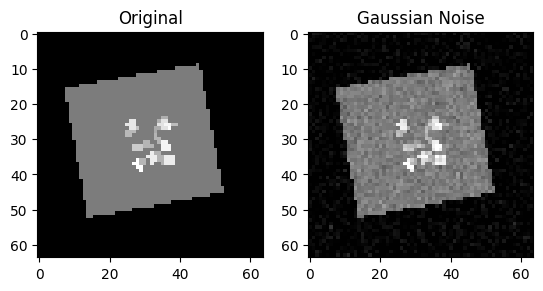

PSNR: 22.9486 -- Target PSNR: 22.6791 -- Noise Level: 0.09 -- Noise Factor: 0.0868


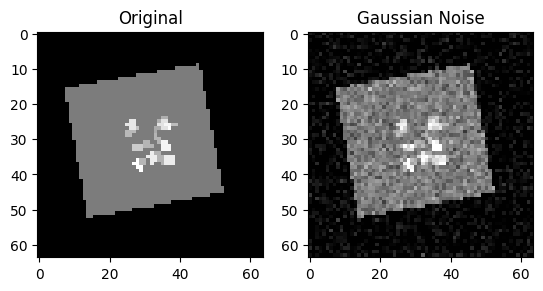

PSNR: 18.7942 -- Target PSNR: 18.2319 -- Noise Level: 0.15 -- Noise Factor: 0.145


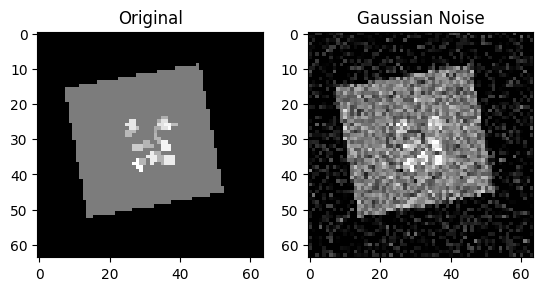

PSNR: 16.3151 -- Target PSNR: 15.7357 -- Noise Level: 0.2 -- Noise Factor: 0.1937


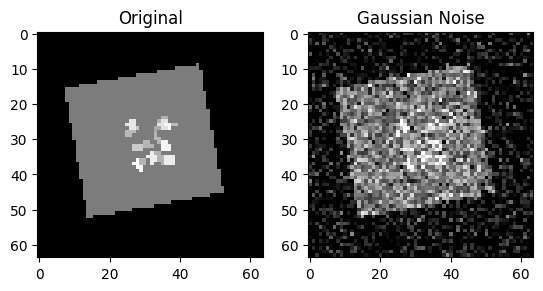

PSNR: 28.0344 -- Target PSNR: 27.7222 -- Noise Level: 0.05 -- Noise Factor: 0.1315


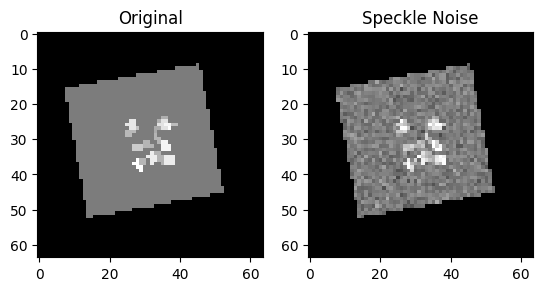

PSNR: 23.2057 -- Target PSNR: 22.6791 -- Noise Level: 0.09 -- Noise Factor: 0.2346


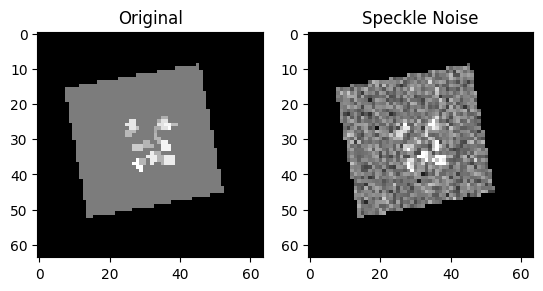

PSNR: 18.6714 -- Target PSNR: 18.2319 -- Noise Level: 0.15 -- Noise Factor: 0.3971


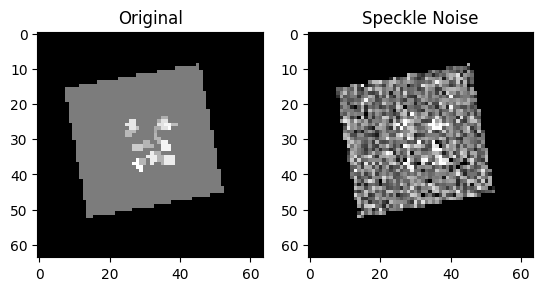

PSNR: 16.1871 -- Target PSNR: 15.7357 -- Noise Level: 0.2 -- Noise Factor: 0.5611


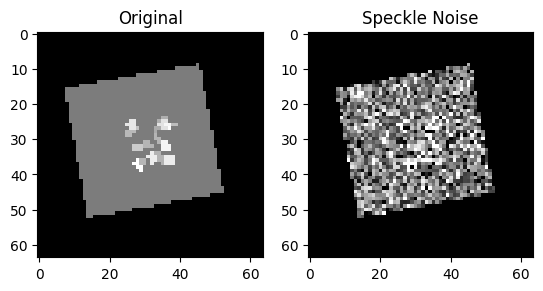

PSNR: 27.8063 -- Target PSNR: 27.7222 -- Noise Level: 0.05 -- Noise Factor: 0.0701


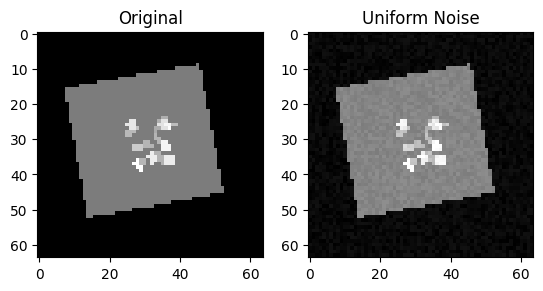

PSNR: 22.7697 -- Target PSNR: 22.6791 -- Noise Level: 0.09 -- Noise Factor: 0.1252


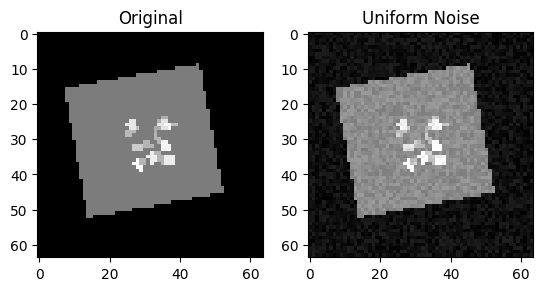

PSNR: 18.3484 -- Target PSNR: 18.2319 -- Noise Level: 0.15 -- Noise Factor: 0.2089


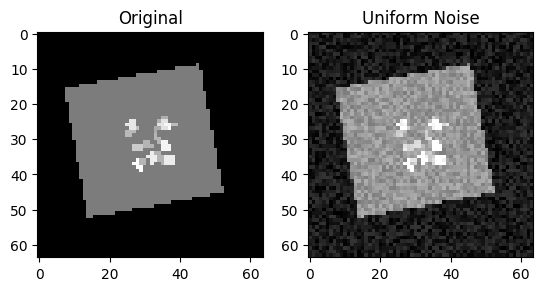

PSNR: 15.8719 -- Target PSNR: 15.7357 -- Noise Level: 0.2 -- Noise Factor: 0.2783


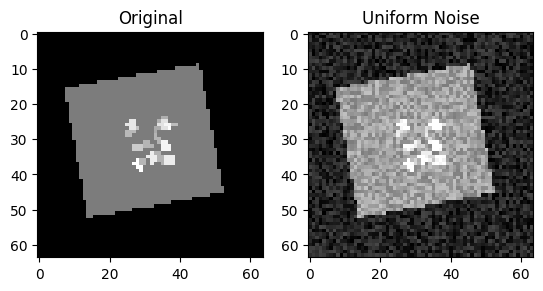

PSNR: 27.9353 -- Target PSNR: 27.7222 -- Noise Level: 0.05 -- Noise Factor: 0.0284


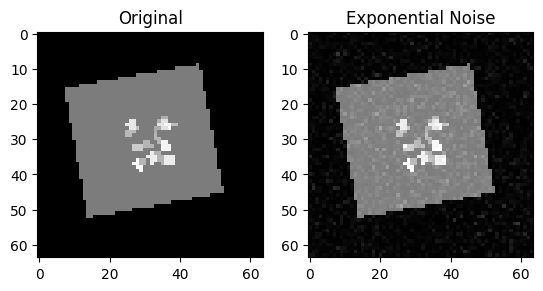

PSNR: 22.827 -- Target PSNR: 22.6791 -- Noise Level: 0.09 -- Noise Factor: 0.0505


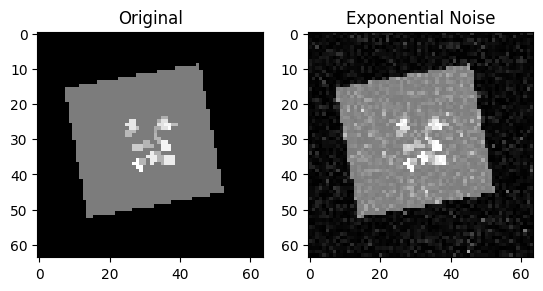

PSNR: 18.6884 -- Target PSNR: 18.2319 -- Noise Level: 0.15 -- Noise Factor: 0.0845


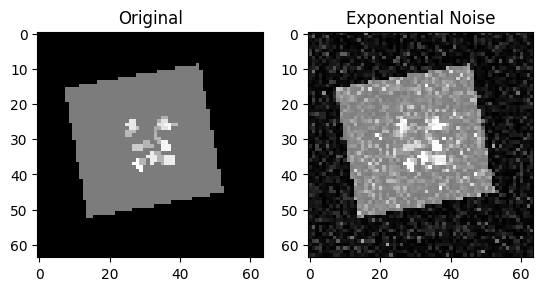

PSNR: 16.1905 -- Target PSNR: 15.7357 -- Noise Level: 0.2 -- Noise Factor: 0.1134


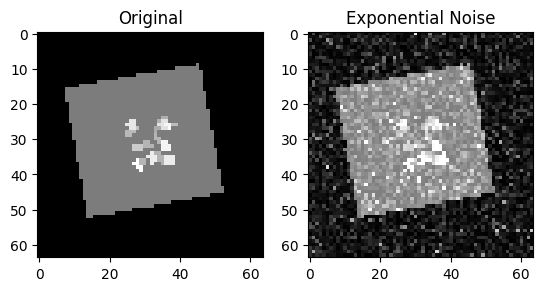

PSNR: 27.8084 -- Target PSNR: 27.7222 -- Noise Level: 0.05 -- Noise Factor: 0.0287


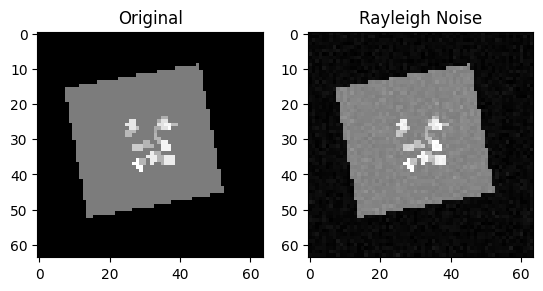

PSNR: 22.765 -- Target PSNR: 22.6791 -- Noise Level: 0.09 -- Noise Factor: 0.0513


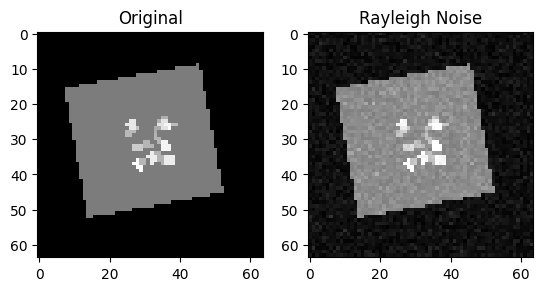

PSNR: 18.6069 -- Target PSNR: 18.2319 -- Noise Level: 0.15 -- Noise Factor: 0.0853


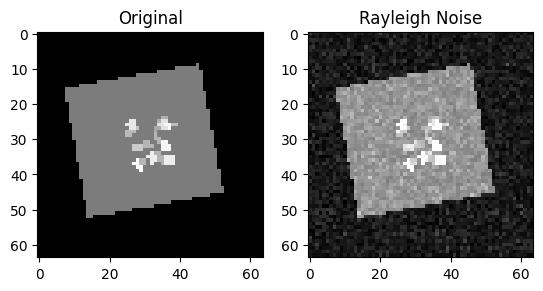

PSNR: 15.9979 -- Target PSNR: 15.7357 -- Noise Level: 0.2 -- Noise Factor: 0.1138


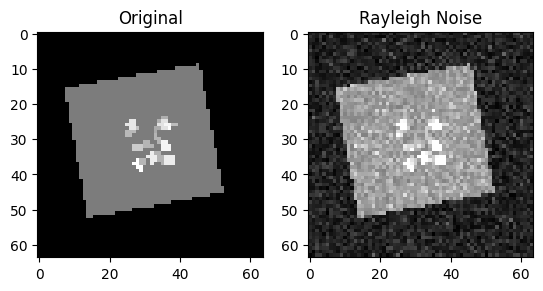

PSNR: 27.7836 -- Target PSNR: 27.7222 -- Noise Level: 0.05 -- Noise Factor: 0.0166


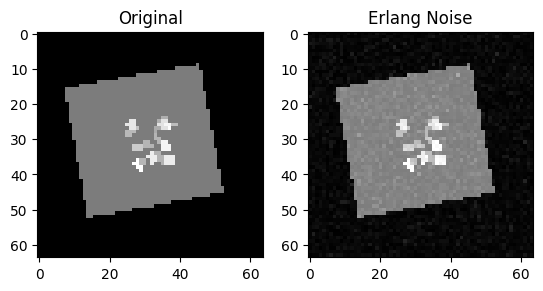

PSNR: 22.7457 -- Target PSNR: 22.6791 -- Noise Level: 0.09 -- Noise Factor: 0.0295


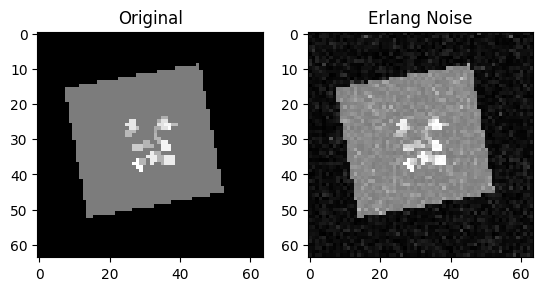

PSNR: 18.563 -- Target PSNR: 18.2319 -- Noise Level: 0.15 -- Noise Factor: 0.0492


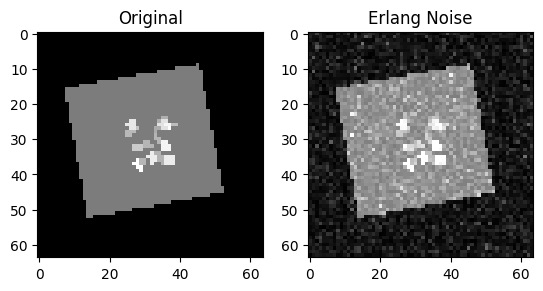

PSNR: 16.0937 -- Target PSNR: 15.7357 -- Noise Level: 0.2 -- Noise Factor: 0.0656


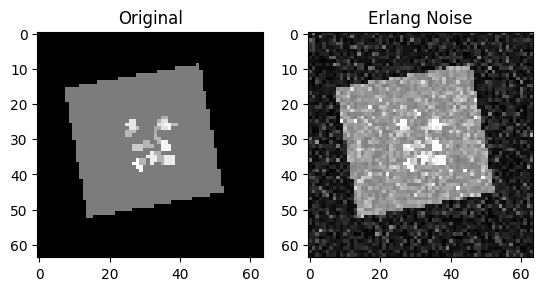

PSNR: 28.0618 -- Target PSNR: 27.7222 -- Noise Level: 0.05 -- Noise Factor: 0.0898


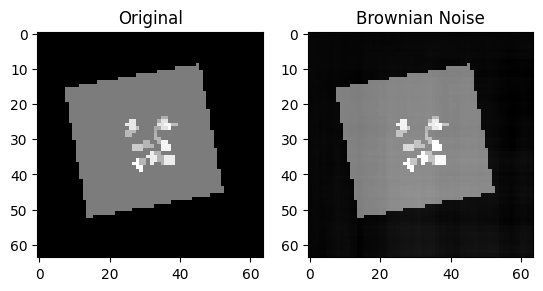

PSNR: 21.5617 -- Target PSNR: 22.6791 -- Noise Level: 0.09 -- Noise Factor: 0.1548


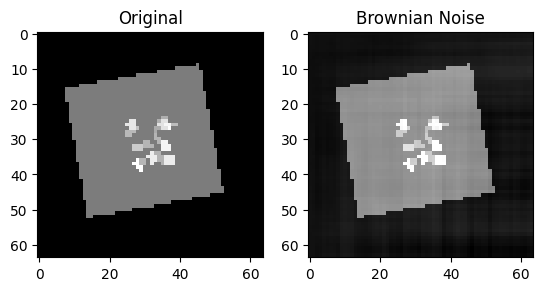

PSNR: 19.1621 -- Target PSNR: 18.2319 -- Noise Level: 0.15 -- Noise Factor: 0.2581


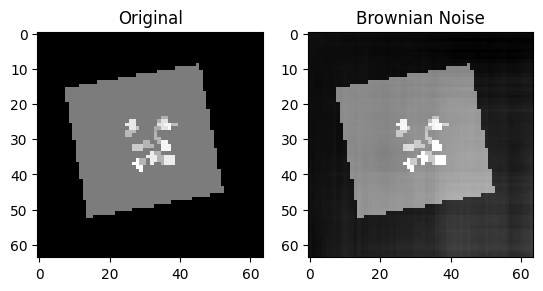

PSNR: 17.9159 -- Target PSNR: 15.7357 -- Noise Level: 0.2 -- Noise Factor: 0.3403


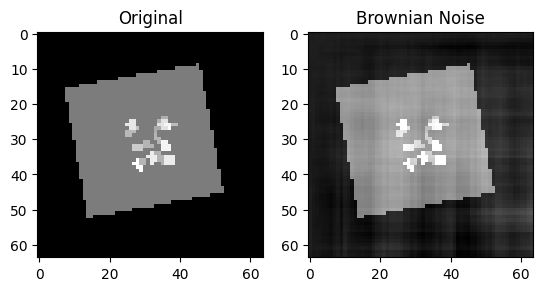

PSNR: 24.8313 -- Target PSNR: 27.7222 -- Noise Level: 0.05 -- Noise Factor: 0.0644


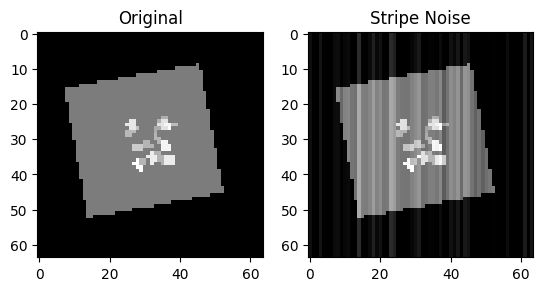

PSNR: 21.0942 -- Target PSNR: 22.6791 -- Noise Level: 0.09 -- Noise Factor: 0.1134


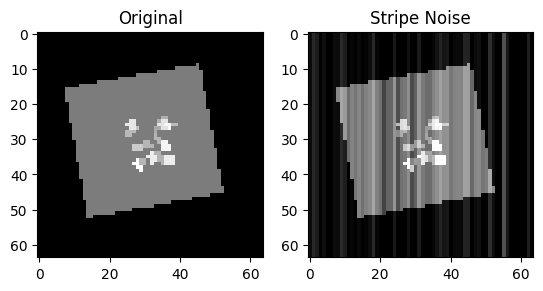

PSNR: 16.0665 -- Target PSNR: 18.2319 -- Noise Level: 0.15 -- Noise Factor: 0.1851


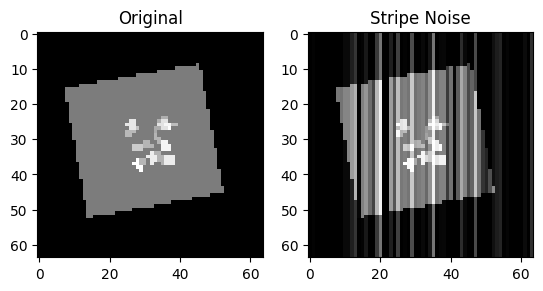

PSNR: 13.974 -- Target PSNR: 15.7357 -- Noise Level: 0.2 -- Noise Factor: 0.2469


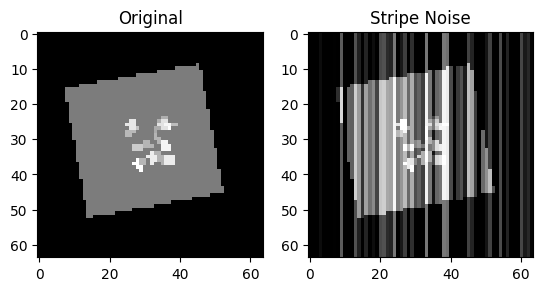

PSNR: 28.2377 -- Target PSNR: 27.7222 -- Noise Level: 0.05 -- Noise Factor: 0.1312


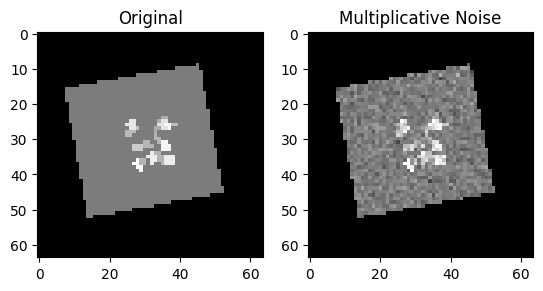

PSNR: 23.0505 -- Target PSNR: 22.6791 -- Noise Level: 0.09 -- Noise Factor: 0.2348


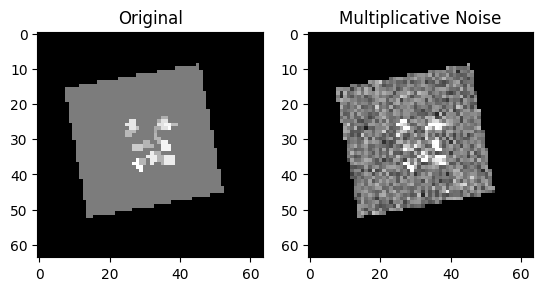

PSNR: 18.4825 -- Target PSNR: 18.2319 -- Noise Level: 0.15 -- Noise Factor: 0.3975


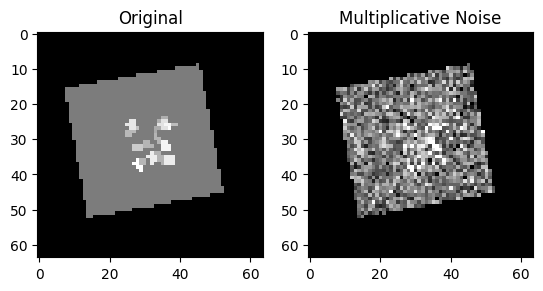

PSNR: 16.1456 -- Target PSNR: 15.7357 -- Noise Level: 0.2 -- Noise Factor: 0.5597


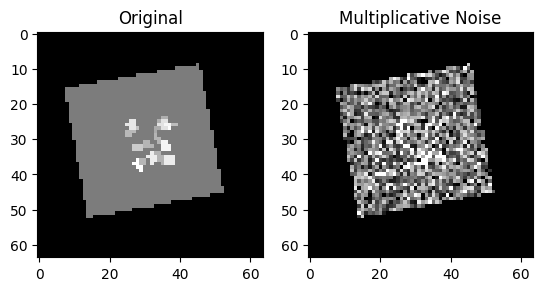

In [37]:
noise_df = pd.read_csv('noise_analysis_64res.csv')
import matplotlib.pyplot as plt
for key in NOISE_FUNCTIONS.keys():
    for res in [6]:
        resolution = 2**res
        for noise_level in [0.05, 0.09, 0.15, 0.20]:
            # Load the phantom
            img = np.load(f'./ground_truth/{2**res}/0.npy').squeeze()
            img_torch = phantom_to_torch(img)
            
            target_psnr = noise_df[
                (noise_df['Noise_Type'] == key) &
                (noise_df['Resolution'] == resolution) &
                (noise_df['NL'] == noise_level)
            ]['PSNR'].values[0]
            
            noise_factor = noise_df[
                (noise_df['Noise_Type'] == key) &
                (noise_df['Resolution'] == resolution) &
                (noise_df['NL'] == noise_level)
            ]['NF1'].values[0]

            # if key == "brownian":
            #     noise_factor *= 1.5

            # if key == "stripe":
            #     noise_factor *= 1.5

            # Add noise to the image
            noise_img = add_selected_noise(img_torch, noise_type=key, noise_factor=noise_factor)

            # calculate the psnr
            psnr = round(compare_psnr(img_torch.numpy(), noise_img.numpy()),4)
            print(f'PSNR: {psnr} -- Target PSNR: {round(target_psnr,4)} -- Noise Level: {round(noise_level,4)} -- Noise Factor: {round(noise_factor,4)}')

            # plot noise image and clean image side by side
            plt.figure()
            plt.subplot(1, 2, 1)
            plt.imshow(img, cmap='gray')
            plt.title('Original')
            plt.subplot(1, 2, 2)
            plt.imshow(noise_img.squeeze(), cmap='gray')
            plt.title(f'{key.capitalize()} Noise')
            # wait a few seconds before move on to allow time to view the image
            plt.show(block=False)
            # plt.imshow(img, cmap='gray')


PSNR: 23.356399209573716


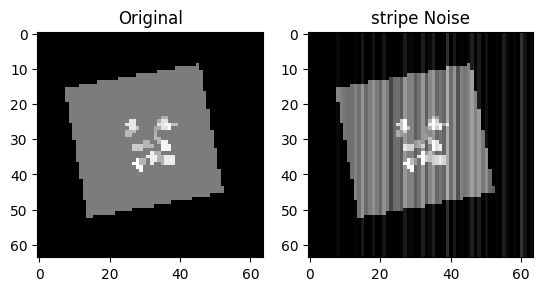

In [24]:
# add stripe noise to an image

img = np.load(f'./ground_truth/64/0.npy').squeeze()
img_torch = phantom_to_torch(img)

# add {type} noise to the image
noise_type = 'stripe'
noise_img = add_selected_noise(img_torch, noise_type=noise_type, noise_factor=0.1)

# plot the images side by side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original')
plt.subplot(1, 2, 2)
plt.imshow(noise_img.squeeze(), cmap='gray')
plt.title(f'{noise_type} Noise')

# calculate the psnr
# these need to be numpy arrays
psnr = compare_psnr(img_torch.numpy(), noise_img.numpy())
print(f'PSNR: {psnr}')

In [36]:
# edit the noise factor in the noise_analysis_64res.csv file
# we want the noise factor to be increased by 1.5 for brownian and stripe noise
# keep the rest of the data the same
df = pd.read_csv('noise_analysis_64res.csv')
df.loc[df['Noise_Type'] == 'brownian', 'NF1'] *= 1.5
df.loc[df['Noise_Type'] == 'stripe', 'NF1'] *= 1.5
df.to_csv('noise_analysis_64res.csv', index=False)

# finally create the images

In [12]:
# finally add the respective noise to the images
# do this only for resolution 64
# and only for the noise types found in the noise_analysis_64res.csv file
# save the results to the respective folders
# structure is ./{noise_type}/resolution_64/noise_level_{noise_level}/phantom_phantomid_noisetype_noiselevel.npy

noise_df = pd.read_csv('noise_analysis_64res.csv')
for key in NOISE_FUNCTIONS.keys():
    for img_id in range(50):
        img_np = np.load(f'./ground_truth/64/{img_id}.npy').squeeze()
        img_torch = phantom_to_torch(img_np)
        for noise_level in [0.05, 0.09, 0.15, 0.20]:
            noise_factor = noise_df[
                (noise_df['Noise_Type'] == key) &
                (noise_df['Resolution'] == 64) &
                (noise_df['NL'] == noise_level)
            ]['NF1'].values[0]
            noise_img = add_selected_noise(img_torch, noise_type=key, noise_factor=noise_factor)
            # save the image
            np.save(f'./{key}/res_64/nl_{noise_level}/p_{img_id}.npy', noise_img.numpy())
            print(f'Completed {key}-{img_id} noise with noise level {noise_level}')

Completed gaussian-0 noise with noise level 0.05
Completed gaussian-0 noise with noise level 0.09
Completed gaussian-0 noise with noise level 0.15
Completed gaussian-0 noise with noise level 0.2
Completed gaussian-1 noise with noise level 0.05
Completed gaussian-1 noise with noise level 0.09
Completed gaussian-1 noise with noise level 0.15
Completed gaussian-1 noise with noise level 0.2
Completed gaussian-2 noise with noise level 0.05
Completed gaussian-2 noise with noise level 0.09
Completed gaussian-2 noise with noise level 0.15
Completed gaussian-2 noise with noise level 0.2
Completed gaussian-3 noise with noise level 0.05
Completed gaussian-3 noise with noise level 0.09
Completed gaussian-3 noise with noise level 0.15
Completed gaussian-3 noise with noise level 0.2
Completed gaussian-4 noise with noise level 0.05
Completed gaussian-4 noise with noise level 0.09
Completed gaussian-4 noise with noise level 0.15
Completed gaussian-4 noise with noise level 0.2
Completed gaussian-5 nois